In [1]:
# Calculate miu_a, miu_s through x*h=y, x = f(miu_a,miu_s);no deconvolution
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
# import tensorflow as tf
# import tensorflow.keras as keras
import math
# from scipy.optimize import fsolve
# from scipy.optimize import root
from scipy.optimize import minimize
from scipy import signal
from scipy import linalg
# import scipy as scp
# import sympy as  syp
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.models import Sequential
import gc

In [48]:
class process_hyperspec(object):
    
    def __init__(self, path, scat):
        self.path = path
        self.scat = scat
        
    def read_data(self):
        ## Read data from txt
        with open(self.path,'r',encoding='utf-8') as f:
            content = f.read()
        
        flag = 0
        for index in range(len(content)):##find the start point  of time and intensity data, pointer is the 'index'
            if (content[index] == '\n') and (flag != 1):
                flag = flag + 1
            elif (content[index] == '\n') and (flag == 1):
                break
            else:
                continue

        # print(content[index+7:len(content)])
        data_ns = pd.read_csv(StringIO(content[index+7:len(content)])) ## Read data of time and wavelengths
        img_nm_ns = np.array(data_ns)    ## Transform to numpy array                                
        self.data_frame = data_ns
        self.data_array = img_nm_ns
        
    def cal_846nm(self):
        time_total, wavelength_total = self.data_array.shape ## Generate an array contains intensity versus time data on 846nm
        data_846nm = np.zeros((time_total,), dtype = float )
        for i in range(wavelength_total):
            data_846nm = self.data_array[:,i] + data_846nm

        return data_846nm/wavelength_total
    
    def return_dataframe(self):
        
        return self.data_frame
    
    def return_array(self):
        return self.data_array

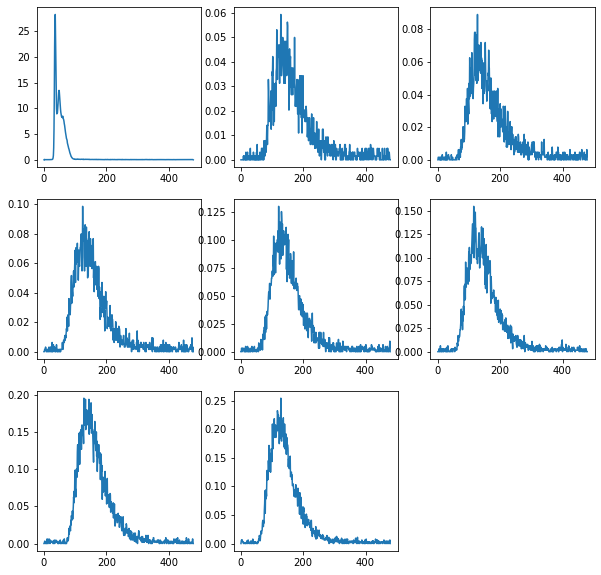

20739

In [51]:
def name_g(i):

    return str(2*i+1)
    
    

dict1 = {i:'s_'+ name_g(i) +'days.txt' for i in range(1, 7)}
dict1[0] = 's_1day.txt'
# dict1[-1] = 'Ref_846nm_5ns.txt'
dict1[-1] = 'Ref_846nm_5ns_15.txt'

N = 8
scat = [None]*N
n_time_labels = 480
data_480multi9 = np.zeros((N, n_time_labels), dtype = float)
for i in range(0, N):
    scat[i] = process_hyperspec(dict1[i-1], i)
    scat[i].read_data()
    data_480multi9[i,:] = scat[i].cal_846nm()

time_index = scat[0].return_dataframe().index

plt.figure(figsize = (10,10))
for i in range(0, N):
    plt.subplot(3,3,i+1)
    plt.plot(data_480multi9[i,:])
    
plt.show()

# print(time_index)

del scat, dict1, name_g, process_hyperspec
gc.collect()

In [50]:
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth



def split_signal(y):
    THRESHOLD_V = 0.02
    for i in range(len(y)):
        if y[i] > THRESHOLD_V and y[i-1] <= THRESHOLD_V:
            index1  = i
        elif y[i] < THRESHOLD_V and y[i-1] >= THRESHOLD_V:
            index2 = i
    y2 = np.zeros((index2 - index1 + 1,))
    y2 = y[index1:index2]
        
    return y2, index1

In [11]:
#Generate h,y(x*h = y)
#===================================================================================================
# data_intensity_extended = np.zeros((N, 959), dtype = float)
# data_intensity_extended[:, 0:479]  = data_480multi9[:,0:479]
# MAX = np.max(data_480multi9)
# # h = smooth(data_480multi9[0,:]/max(data_480multi9[0,:]), 10) #x*h = y ; x.shape = (480,) h.shape = (480,) y.shape = (959,)
# h = smooth(data_480multi9[0,:]/MAX, 10)

# y =np.zeros((N,959))
# for i in range(0,N):
#     y[i,:] = smooth(data_intensity_extended[i,:]/max(data_intensity_extended[i,:]), 10)
    
#======================================================================================================

In [52]:
data_intensity_extended = np.zeros((N, 959), dtype = float)
data_intensity_extended[:, 0:479]  = data_480multi9[:,0:479]

# h = smooth(data_480multi9[0,:], 1)
h = data_480multi9[0,:]

y =np.zeros((N,959))
for i in range(0,N):
    # y[i,:] = smooth(data_intensity_extended[i,:], 1)
    y[i,:] = data_intensity_extended[i,:]

In [53]:
class calculate_miu_s(object):
    
    def __init__(self, h, y, time_index, k):
        self.h = h
        self.y = y
        self.time = time_index
        self.k = k
        return None
    
    def transmittance(self, d, t, c, g, miu_a, miu_s):
        miu_s_prime = (1-g)*miu_s
        Z0 = 1/(miu_s_prime)
        D = 1/(3*(miu_a + miu_s_prime))
        h1 = math.pow(4*math.pi*D*c, -0.5)
        h2 = math.pow(t, -1.5)*math.exp(-miu_a*c*t)
        h3 = (d-Z0)*math.exp(-(math.pow(d-Z0, 2))/(4*D*c*t))
        h4 = (d+Z0)*math.exp(-(math.pow(d+Z0, 2))/(4*D*c*t))
        h5 = (3*d-Z0)*math.exp(-(math.pow(3*d-Z0, 2))/(4*D*c*t))
        h6 = (3*d+Z0)*math.exp(-(math.pow(3*d+Z0, 2))/(4*D*c*t))
    #     return d,Z0,D,c,t
        return h1*h2*(h3-h4+h5-h6)
    
    
    def error_cal(self, x):
        miu_s = x[0]
        miu_a = x[1]
        k = self.k
        # k     = x[2]  
        # k = 0.1
        # miu_a = 0.01e2
        g = 0.7
        d = 0.01
        # t = 300e-12
        c = 3e8/1.3314
        T = int(480)
#         time = np.array(range(1,T, 1))
#         time = time*1e-8*0.010345058455114822
        time = self.time*1e-9
        miu_s = miu_s*1e4
        intensity1 = np.zeros((T, ), dtype = float)
        for i in range(time.shape[0] - 1):

            intensity1[i] = calculate_miu_s.transmittance(self, d, time[i], c, g, miu_a, miu_s)
        
        y2 = np.convolve(intensity1, self.h)
        self.intensity = intensity1
        self.y_convolved = y2
        # y2 = y2/max(y2)
        y2 = y2*k*1e-9
        return np.sum(abs(y2 - self.y))
#         return time

    def get_convolved_signal(self):
        return self.y_convolved
        
    def get_x(self):
        return self.intensity

In [20]:
rr = calculate_miu_s(h, y[1,:], time_index)
minimize(rr.error_cal, x0 = [3, 6, 4], method  = 'Nelder-Mead', options={"xtol" : 1e-10, "disp":True})

Optimization terminated successfully.
         Current function value: 0.653765
         Iterations: 330
         Function evaluations: 592


 final_simplex: (array([[2.87436248, 4.71810427, 0.06306293],
       [2.87436248, 4.71810427, 0.06306293],
       [2.87436248, 4.71810427, 0.06306293],
       [2.87436248, 4.71810427, 0.06306293]]), array([0.65376457, 0.65376457, 0.65376457, 0.65376457]))
           fun: 0.65376457484052
       message: 'Optimization terminated successfully.'
          nfev: 592
           nit: 330
        status: 0
       success: True
             x: array([2.87436248, 4.71810427, 0.06306293])

In [34]:
def get_error(x):    
    k = x[0]
    m = [None]*(N-1)
    sum_fun = 0
    for i in range(1,N):
        m[i-1] = calculate_miu_s(h, y[i], time_index, k)
        sum_fun = sum_fun + abs(minimize(m[i-1].error_cal, x0 = [3,6], method  = 'Nelder-Mead', options={"xtol" : 1e-20, "disp":True}).fun)
    return sum_fun

In [36]:
minimize(get_error, x0 = [0.1], method  = 'Nelder-Mead')

Optimization terminated successfully.
         Current function value: 2.206838
         Iterations: 129
         Function evaluations: 286
Optimization terminated successfully.
         Current function value: 2.571085
         Iterations: 183
         Function evaluations: 372
Optimization terminated successfully.
         Current function value: 4.810809
         Iterations: 154
         Function evaluations: 306
Optimization terminated successfully.
         Current function value: 3.753011
         Iterations: 155
         Function evaluations: 314
Optimization terminated successfully.
         Current function value: 1.464539
         Iterations: 143
         Function evaluations: 285
Optimization terminated successfully.
         Current function value: 2.197906
         Iterations: 147
         Function evaluations: 297
Optimization terminated successfully.
         Current function value: 2.570354
         Iterations: 159
         Function evaluations: 317
Optimization termina

 final_simplex: (array([[0.33867188],
       [0.33859375]]), array([17.37299673, 17.37299744]))
           fun: 17.37299672782606
       message: 'Optimization terminated successfully.'
          nfev: 32
           nit: 16
        status: 0
       success: True
             x: array([0.33867188])

In [54]:
miu_s_get = np.zeros((N-1,2))
m = [None]*(N-1)
fun_value = np.zeros((7,))
k = 0.33867188
for i in range(1,N):
    m[i-1] = calculate_miu_s(h, y[i], time_index, k)
    minu = minimize(m[i-1].error_cal, x0 = [3,6], method  = 'Nelder-Mead', options={"xtol" : 1e-20, "disp":True})
    miu_s_get[i-1,:], fun_value[i-1] = minu.x, minu.fun

Optimization terminated successfully.
         Current function value: 1.461560
         Iterations: 140
         Function evaluations: 287
Optimization terminated successfully.
         Current function value: 2.639565
         Iterations: 136
         Function evaluations: 259


15.173905769621786
[1.46155964 1.85216264 1.87301148 1.8677464  2.30934164 3.17051912
 2.63956485]


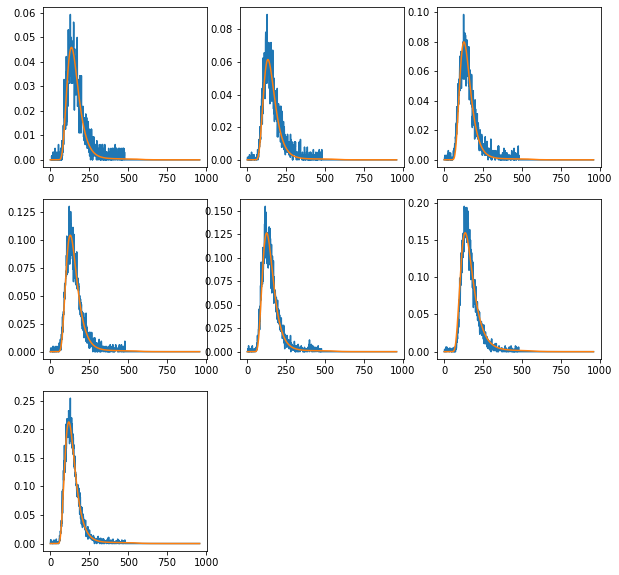

In [55]:
print(np.sum(abs(fun_value)))
print(fun_value)
plt.figure(figsize = (10,10))
for i in range (0, 7):
    yk = m[i].get_convolved_signal()
    plt.subplot(3,3,i+1)
    plt.plot(y[i+1])
    plt.plot(yk*k*1e-9)
plt.show()

In [35]:
# miu_s_get = np.array([[0.24,0.64],[0.56,0.91],[0.85,0.81],[1.24,0.79],[1.27,0.31],[1.51,0.30],[1.76,0.29],[2.44,0.51]])

In [57]:
miu_s_get

array([[3.9930833 , 9.35244295],
       [3.74306756, 9.1056888 ],
       [3.41804852, 9.44442661],
       [3.35215541, 8.41431385],
       [3.14997924, 8.49330909],
       [3.37508089, 6.13732019],
       [2.74584994, 8.05128486]])

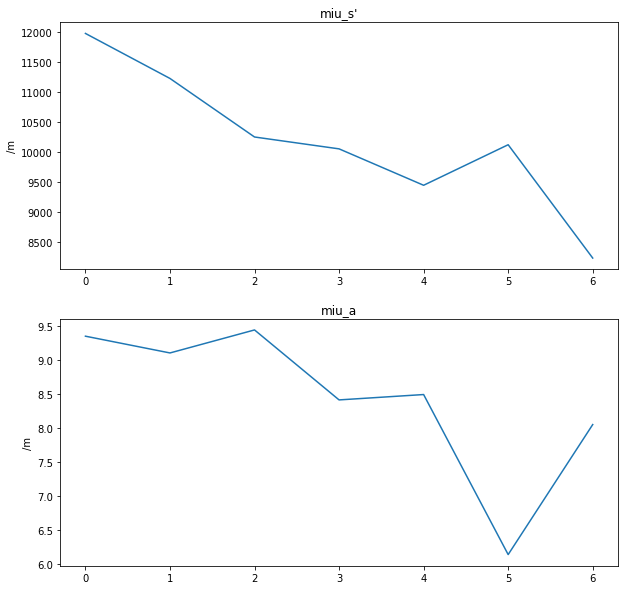

In [56]:
plt.figure(figsize = (10,10))
plt.subplot(2,1,1)
plt.title("miu_s'") # 图形标题
# plt.xlabel("") # x轴名称
plt.ylabel("/m") # y 轴名称
plt.plot(miu_s_get[:,0]*1e4*0.3)
plt.subplot(2,1,2)
plt.title("miu_a") # 图形标题
# plt.xlabel("") # x轴名称
plt.ylabel("/m") # y 轴名称
plt.plot(miu_s_get[:,1])
plt.show()